## Learning G-equivariant Representation

In this question, we will learn a G-equivariant MLP Auto-Encoder.

- Task: Simply reconstruct the input MNIST handwritten digit with your MLP.

- Training data
    - Consider the MNIST dataset of handwritten digits:
<center><img src="example_image.png" width=300px /></center>
    - The above dataset contains mostly upright digits that we will give as input to our MLP training.

- Now consider the following out-of-distribution test data
    - Consider the transformation group $G_\text{rot} \equiv \{T^{(\theta)}\}_{k\in \{0^\circ,90^\circ,180^\circ,270^\circ\}}$, which rotates the image by $\theta$ degrees, where $T^{(0)}$ is the identity transformation.
    - The input to the transformation group is ${\bf x}$, the **vectorized** image, and we aim to reconstruct the input image using our Auto-Encoder model
    - The Kronecker product in pytorch can be invoked as ```torch.kron```

- Task: Training a G-equivariant MLP auto-encoder over the standard (upright) MNIST data.
    - That is, if your MLP receives a rotated MLP in the test data, it will try to output the same rotated image

A standard MLP trained on mostly upright images, will be confused when we give out-of-distribution (rotated) data. For instance output of a simple Auto-Encoder model that it does not work on rotated input:
<center><img src="example-ae-output.png" width=300px /></center>

- We can observe that, for a standard MLP, the reconstructed output is a much worse for a rotated input than the original MNIST input. 

# Your Task:
**In what follows, you are required to fill in the code for constructing a G-equivairant Auto-Encoder model that is able to correct reconstruct the out-of-distribution (rotated) MNIST images.**

We first review some concepts from the class.
### G-equivariant Representations

- Consider an input in $\mathbb{R}^m$.
- And the output in $\mathbb{R}^k$.
- Let ${\bf W} \in \mathbb{R}^{k \times m}$ be the neuron parameters
- Equivariance requires that transforming the input is the same as transforming the output: $$
{\bf x} \in \mathbb{R}^m, \forall g \in G , \quad \rho_2(g) {\bf W} {\bf x} =  {\bf W} \rho_1(g) {\bf x},
$$ where $\rho_1:G \to \mathbb{R}^{\sqrt{m} \times \sqrt{m}}$ and $\rho_2:G \to \mathbb{R}^{\sqrt{k} \times \sqrt{k}}$. (Thus we require $k$ and $m$ to be perfect square numbers.)
- Since the above is true for all ${\bf x}$, then  $$\rho_2(g) {\bf W} \rho_1(g)^{-1} =  {\bf W},$$
or equivalently  $$\forall g \in G, \qquad \rho_2(g) \otimes \rho_1(g^{-1})^T \text{vec}({\bf W})  =  \text{vec}({\bf W}),$$ where vec flattens the matrix into a vector, and so the whole transformation is $\rho_2(g) \otimes \rho_1(g^{-1})^T = \rho_{12}(g)$ that is a representation of how $g$ acts on matrices mapping from $A_1 \to A_2$.

### Group-Equivariant ($G$-Equivariant) Neurons

- Note that equation $$\forall g \in G, \qquad \rho_2(g) \otimes \rho_1(g^{-1})^T \text{vec}({\bf W})  =  \text{vec}({\bf W})$$ has a familiar form.
    - We can rewrite the above equation as $$T {\bf x} = {\bf x},$$ where $T = \rho_2(g) \otimes \rho_1(g^{-1})^T$ and ${\bf x} = \text{vec}({\bf W}).$
    
- The above is the equation required for a $G$-invariant representation.
    - We can again use the Reynolds operator to find $\bar{T}$ such that $\forall {\bf x} \in \mathbb{R}^{mk}$ and $$\forall T \in \{\rho_2(g) \otimes \rho_1(g^{-1})^T : \forall g \in G\}$$ such that $$\bar{T}(T {\bf x}) = \bar{T} {\bf x}.$$
    

### First: Get the eigenvectors of the symmetrization (Reynolds) operator

- To obtain the Reynolds operator, we first need to construct the transformation matrix for $\forall T \in \{\rho_2(g) \otimes \rho_1(g^{-1})^T : \forall g \in G\}$
    - We will first calculate the transformation matrix for $\rho_1(g)$ and $\rho_2(g^{-1}), \forall g\in G$
    - Then we will do the Kronecker product between $\rho_1(g)$ and $\rho_2(g^{-1}), \forall g\in G$
    - As said in class, we will construct the transformation matrix through one-encoded vector
    - Finally, we are able to get the matrix of the symmetrization (Reynolds) operator.

In [1]:
import torch
import torch.nn as nn

import numpy as np

from tqdm import tqdm
from torchvision.utils import save_image, make_grid
from torch import optim
from torchvision import datasets, transforms
import multiprocessing as mp
from functools import partial
import matplotlib.pyplot as plt

/home/roy206/.conda/envs/cent7/2020.11-py38/NWRGAE/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Define 90-rotation function.
def rotate_array(array, degree):
    if (array.ndim == 2 and degree % 90 == 0):
        return np.rot90(array, degree // 90)
    else:
        print("Can only rorate 2D array by 90n degrees.")
        raise RuntimeError
        
# Define the rotation over the one-hot vector with a specific degree and shape
def transformed_onehot_degree(onehot_loc, transform_func, shape, degree):
    # Get flattened onehot.
    numel = np.prod(shape)
    onehot = np.zeros(numel)
    onehot[onehot_loc] = 1

    # Transform onehot with specific shape view and flatten back.
    transformed_vec = transform_func(onehot.reshape(*shape), degree)
    return transformed_vec.reshape(numel)

Then we define the function to obtain the equivariant subspace. 
**Note that there are missing parts in the code for you to fill in (marked with TODO).**

In [3]:
# Define number of CPUs to use for subspace generation.
NUM_TRANSFORM_CPUS = 4

#Important variables
#  - transform_mat is out Reynolds operator \bar{T}
#  - eigenvectors are the eigenvectors of \bar{T}

# Apply given transformation on onehot corresponding to each pixel of 2D image.
# Use Python multiprocessing since it is work with numpy array.
# If it is torch Tensor, it is recommended to use PyTorch wrapped version of
# multiprocessing (torch.multiprocessing).
# Here we need to both transforma map over the input shape and output shape
def get_equivariant_subspace(transform_func, shape1, shape2):
    # Use multiprocessing to get transformation matrix correspond to given
    # transformation function by paralleling onehot dimensions.
    buf = [] # store the transformation map for each degree rotation
    for degree in (0, 90, 180, 270): # for each degree, we need to calculate $\rho_2(g) \otimes \rho_1(g^{-1})^T$
        n1 = int(np.sqrt(shape1))
        assert n1*n1 == shape1  # the vector dimension must be a perfect square number
        pool = mp.Pool(NUM_TRANSFORM_CPUS)
        trans_mat1 = pool.map(
            partial(
                transformed_onehot_degree,
                transform_func=transform_func, shape=(n1,n1), degree=360-degree,
            ),
            range(shape1),
        )
        pool.close()
        pool.join()
        trans_mat1 = np.stack(trans_mat1,axis=1) # calculate the transformation map for \rho_1(g^{-1})
        
        n2 = int(np.sqrt(shape2))
        assert n2*n2 == shape2  # the vector dimension must be a perfect square number
        pool = mp.Pool(NUM_TRANSFORM_CPUS)
        trans_mat2 = pool.map(
            partial(
                transformed_onehot_degree,
                transform_func=transform_func, shape=(n2,n2), degree=degree,
            ),
            range(shape2),
        )
        pool.close()
        pool.join()
        trans_mat2 = np.stack(trans_mat2,axis=1) # calculate the transformation map for \rho_2(g)
        
        # TODO: Fill in the space below 
        # To obtain the transformation map for $\rho_2(g) \otimes \rho_1(g^{-1})^T$ for each degree rotation
        trans_mat = np.kron(trans_mat2, trans_mat1.T)
        buf.append(trans_mat)
    
    transform_mat = sum(buf) / len(buf) 
    # To obtain the symmetrization (Reynolds) operator of the group {\rho_2(g) \otimes \rho_1(g^{-1})^T : \forall g \in G\}
        

    # Eigenvectors is used to describe the transformation subspace.
    # Use right side of decomposition thus eigenvectors are located at rows.
    # Transformation matrix is assumed to be real symmetric
    # TODO: Fill in the space below to obtain the eigenvectors
    _, eigenvalues, eigenvectors = np.linalg.svd(transform_mat,hermitian=True)

    # Eigenvalues are sorted from high to low, thus for over rank eigenvectors,
    # they are null eigenvectors assigned with 0 eigenvalues.
    # We should focus on non-trival eigenvectors.
    rank = np.linalg.matrix_rank(np.diag(eigenvalues),hermitian=True)
    
    eigenvectors = eigenvectors[:rank]
    return transform_mat, eigenvectors.T, eigenvalues


### Eigenvectors of the Reynolds Operator
We show an example of the eigenvectors of the Reynolds Operator for input space $\mathbb{R}^{14\times 14}$ and output space $\mathbb{R}^{6\times 6}$. Students can rerun the cell below to verify if the eigenvetors you get match the correct eigenvectors

The Reynolds operator tranformation matrix has dimension (7056, 7056)
The subspace W is the subspace span by 1764 eigenvectors
--- First 16 eigenvectors shown as images ---


/tmp/ipykernel_232212/2352988640.py:34: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[j%maxCols].set_xticklabels([0] + [0, 1, 2] * 3)


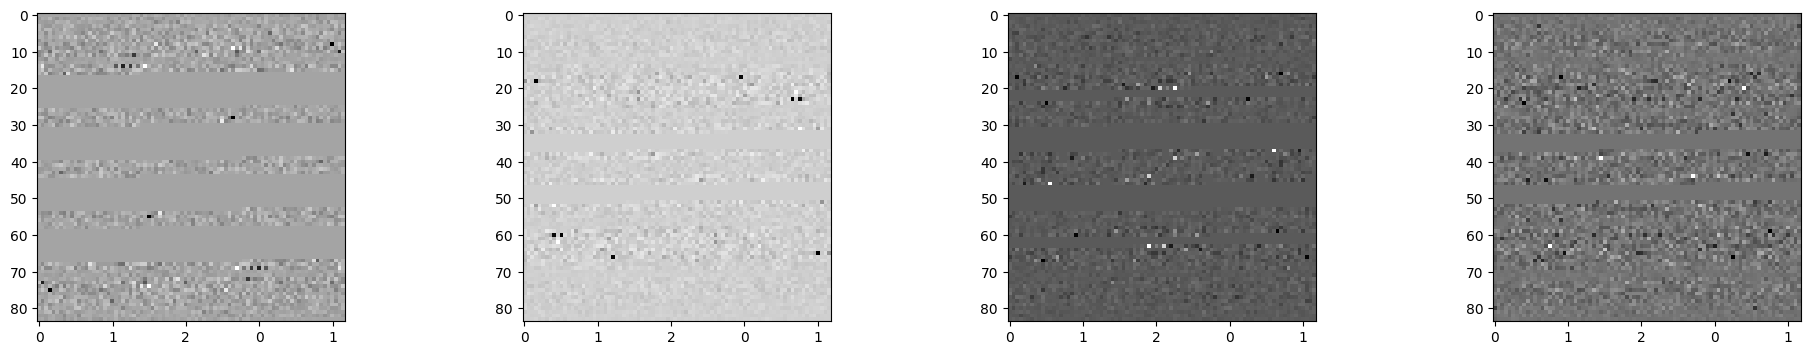

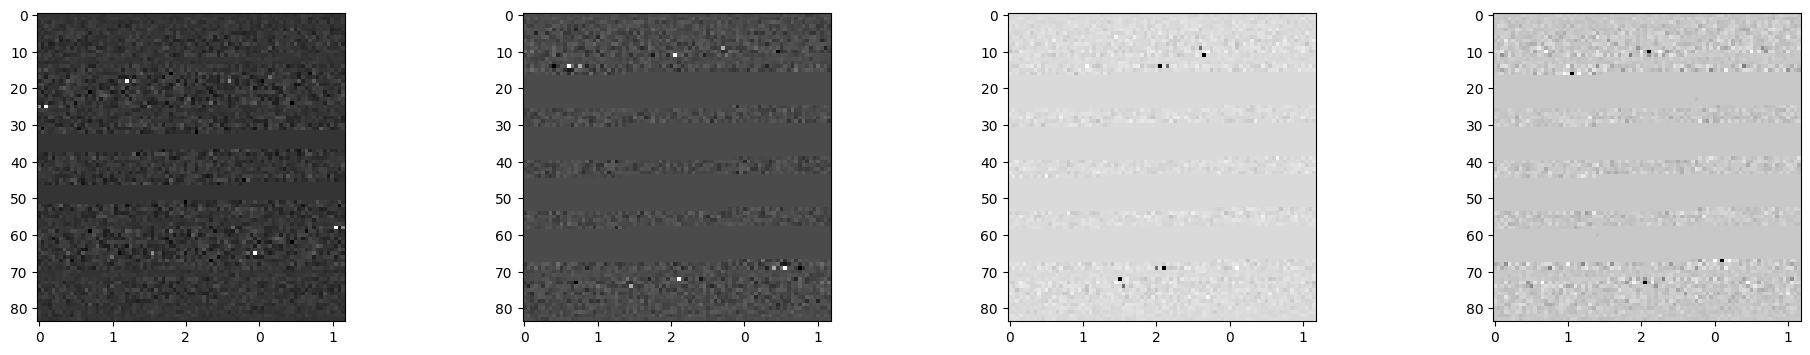

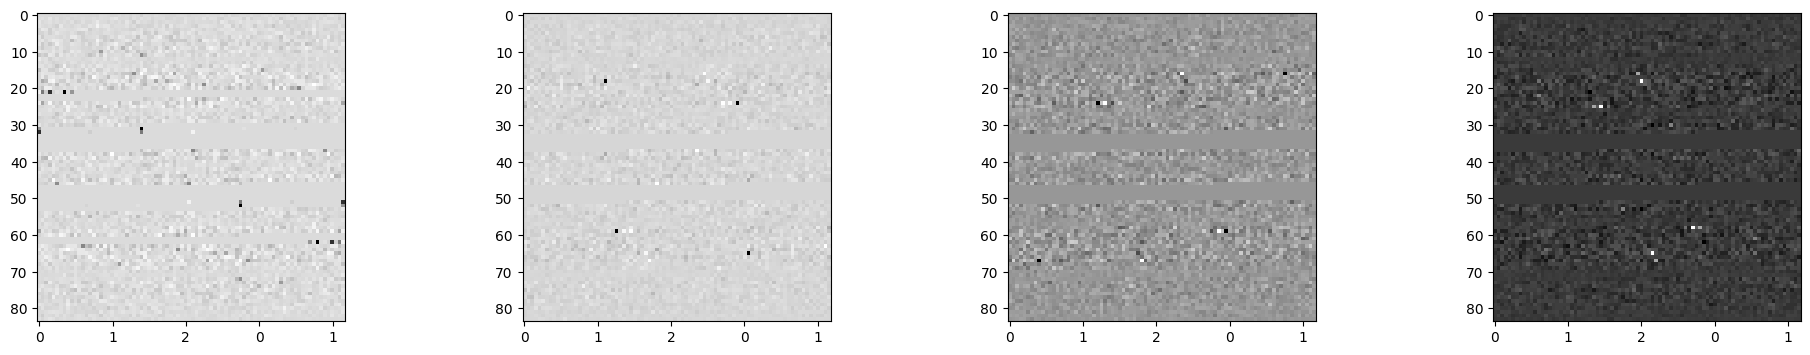

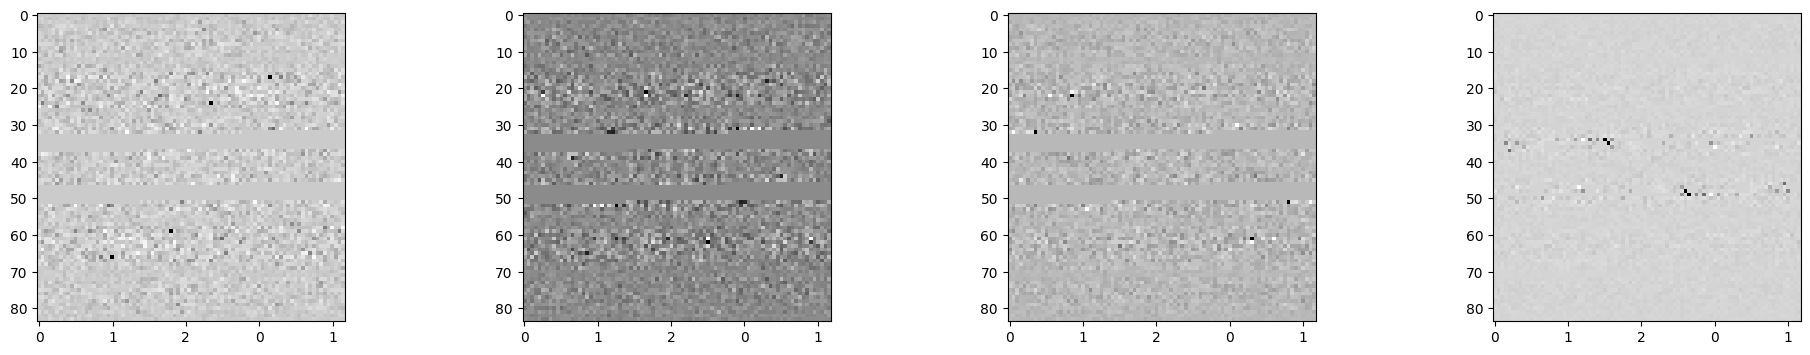

In [4]:
def showSubspace(subspace, Wshape, ndim=-1, channels=False):
    subspace = subspace.T

    if ndim == -1:
        ndim = subspace.shape[0]
    subspace = subspace[:ndim]

    ndim = subspace.shape[0]
    maxCols = min(ndim, 4)

    for j in range(ndim):
        if j % maxCols == 0:
            plt.show()
            nCols = maxCols if ndim - j > maxCols else ndim - j
            fig, axes = plt.subplots(1, nCols, figsize=(12 * nCols // 2, 9 // 2))
            try:
                
                axes[0]
            except:
                axes = [axes]

        kernel = subspace[j]
        kernel = kernel.reshape(*Wshape)

        if len(kernel.shape) == 3:
            kernel = kernel.transpose(1, 2, 0)
            if channels:
                kernel = np.concatenate([kernel[:, :, c] for c in range(kernel.shape[-1])], axis=1)
                axes[j%maxCols].add_patch(patches.Rectangle((-0.45, -0.45), 2.95, 2.95, facecolor='none', linestyle='--', linewidth=2, edgecolor='tab:red'))
                axes[j%maxCols].add_patch(patches.Rectangle((2.55, -0.45), 2.95, 2.95, facecolor='none', linestyle='--', linewidth=2, edgecolor='tab:green'))
                axes[j%maxCols].add_patch(patches.Rectangle((5.55, -0.45), 2.95, 2.95, facecolor='none', linestyle='--', linewidth=2, edgecolor='tab:blue'))

        axes[j%maxCols].imshow(kernel.round(decimals=6), cmap="Greys")
        axes[j%maxCols].set_xticklabels([0] + [0, 1, 2] * 3)

    plt.show()

transform_mat, eigenvectors, eigenvalues = get_equivariant_subspace(rotate_array, 14*14, 6*6)

print(f"The Reynolds operator tranformation matrix has dimension {transform_mat.shape}")
print(f"The subspace W is the subspace span by {eigenvectors.shape[1]} eigenvectors")
print("--- First 16 eigenvectors shown as images ---")
showSubspace(eigenvectors, (14*6, 14*6), ndim=16, channels=False)

### Standard Auto-Encoder

- **First, we will test the performance of a standard Auto-Encoder**
- The Original Train data contains regular MNIST images (shrink the resolution to $14\times 14$ to ease computation)
- The In-distribution Original Test data contains regular MNIST images
- The Out-of-distribution Rotated Test data contains rotated MNIST images (rotated at random)

In [5]:
# We first construct a standard Auto-Encoder
class AutoEncoder(nn.Module):
    def __init__(self):
        super(AutoEncoder, self).__init__()
        
        # We will later replace the linear layers with a G-equivariant layers.
        # Rest of the code remains the same.
        self.encoder = nn.Sequential(
                nn.Linear(14*14, 36), # We fix the latent dimension
                nn.ELU(),
                nn.Linear(36, 9),
                nn.ELU()
            )

        self.decoder = nn.Sequential(
                nn.Linear(9, 36),
                nn.ELU(),
                nn.Linear(36, 14*14)
            )


    def forward(self, x):
        h = self.encoder(x)
        return self.decoder(h)


In [6]:
# We write our train and test functions here
def train_ae(train_loader, model, loss_fn, optimizer, epoch, device):

    model.train()
    train_loss = 0
    for batch_idx, (data, _) in enumerate(train_loader):

        # Reshaping the image to (-1, 14*14)
        data = data.reshape(-1, 14*14)
        data = data.to(device)

        optimizer.zero_grad()

        recon_batch = model(data) # reconstruct the dataset

        loss = loss_fn(recon_batch, data)

        loss.backward()
        train_loss += loss.item()
        optimizer.step()

    print('====> Epoch: {} Average loss: {:.6f}'.format(
          epoch, train_loss / len(train_loader.dataset)))
    
def test_ae(test_loader, model, loss_fn, device, rotation=False):
    torch.manual_seed(42)
    model.eval()
    test_loss = 0
    for batch_idx, (data, _) in enumerate(test_loader):
        
        if rotation:
            # we will randomly rotate the input to construct the rotated test dataset
            k = torch.randint(1, 4, (1,)) # randomly select a k for the rotation 90*k
            data = torch.rot90(data, 1, [2, 3]) 
        # Reshaping the image to (-1, 14*14)
        data = data.reshape(-1, 14*14)
        data = data.to(device)


        recon_batch = model(data) # reconstruct the dataset

        loss = loss_fn(recon_batch, data)
        
        test_loss += loss.item()
    
    return test_loss/ len(test_loader.dataset)

We will then load the data and train the model.

In [7]:
lr = 1e-3
from torch.utils.data import DataLoader

# set seed
torch.manual_seed(42)
np.random.seed(42)
device = torch.device("cuda") if torch.cuda.is_available() else "cpu"

# We will throw away the training labels during training

import torchvision.transforms as transforms

resize = transforms.Resize(size=(14, 14)) # We will shrink the size of the image for ease of computation
transform = transforms.Compose([resize, transforms.ToTensor()])

mnist_train = datasets.MNIST(root='../data_equi', train=True, transform=transform, download=True)
mnist_test = datasets.MNIST(root='../data_equi', train=False, transform=transform, download=True)

kwargs = {'num_workers': 1, 'pin_memory': True} 
train_loader = DataLoader(dataset=mnist_train, batch_size=128, shuffle=True, **kwargs)
test_loader = DataLoader(dataset=mnist_test, batch_size=128, shuffle=True, **kwargs)

ae = AutoEncoder().to(device)

ae_optimizer = optim.Adam(ae.parameters(), lr=lr)
ae_loss_fn = torch.nn.MSELoss() # We use MSE loss for Auto-Encoder reconstruction

for epoch in range(1, 20):
    train_ae(train_loader, ae, ae_loss_fn, ae_optimizer, epoch, device)

====> Epoch: 1 Average loss: 0.000198
====> Epoch: 2 Average loss: 0.000108
====> Epoch: 3 Average loss: 0.000102
====> Epoch: 4 Average loss: 0.000095
====> Epoch: 5 Average loss: 0.000090
====> Epoch: 6 Average loss: 0.000086
====> Epoch: 7 Average loss: 0.000083
====> Epoch: 8 Average loss: 0.000081
====> Epoch: 9 Average loss: 0.000079
====> Epoch: 10 Average loss: 0.000077
====> Epoch: 11 Average loss: 0.000076
====> Epoch: 12 Average loss: 0.000075
====> Epoch: 13 Average loss: 0.000074
====> Epoch: 14 Average loss: 0.000074
====> Epoch: 15 Average loss: 0.000073
====> Epoch: 16 Average loss: 0.000073
====> Epoch: 17 Average loss: 0.000072
====> Epoch: 18 Average loss: 0.000072
====> Epoch: 19 Average loss: 0.000071


In [8]:
test_loss = test_ae(test_loader, ae, ae_loss_fn, device)
test_rotat_loss = test_ae(test_loader, ae, ae_loss_fn, device, rotation=True)
print("For a standard Auto-Encoder model")
print("In-distribution Test Loss", "{:.6f}".format(test_loss))
print("Out-of-distribution (Rotated)  Test Loss", "{:.6f}".format(test_rotat_loss))

For a standard Auto-Encoder model
In-distribution Test Loss 0.000071
Out-of-distribution (Rotated)  Test Loss 0.000199


We can observe the difference in loss for *in-distribution* and *out-of-distribution* test data.

### G-Equivariant Auto-Encoder

- **First, we will test the performance of a G-equivariant Auto-Encoder**
- The original training data contains (mostly) upright MNIST images (we scale the images to $14\times 14$ to simplify the computation)
- The **in-distribution test** data contains regular **test** MNIST images
- The **out-of-distribution test** data contains rotated MNIST images (rotated at random)

In the following, we define the GEquivariantLayer() and GEquivariantAutoEncoder() class. 

**Note that there are missing parts in the code for you to fill (marked with TODO).**

In [35]:
class GEquivariantLayer(nn.Module):
    
    def __init__(self, input_dim, output_dim):
        super(GEquivariantLayer,self).__init__()
        
        self.input_dim = input_dim 
        self.output_dim = output_dim
        # Load the left 1-eigenvectors of the Reynolds operator that we computed before.
        _, eigenvectors, _ = get_equivariant_subspace(rotate_array, self.input_dim, self.output_dim)
        eigentensor = torch.from_numpy(eigenvectors).float()
        self.basis = eigentensor.T
        
        self.coeffs = nn.Parameter(torch.Tensor(self.basis.shape[0], 1))
        # TODO: Fill the parameter dimension of the bias term
        self.bias = nn.Parameter(torch.Tensor(1, 1))
        # WARNING: Careful with the bias so it does not break the equivariance.
        
        stdv = 1.0/np.sqrt(output_dim)
        self.coeffs.data.uniform_(-stdv, stdv)
        self.bias.data.zero_()
    

    def forward(self, X):
        # Input shape: torch.Size([minibatch, input_dim])
        
        # if self.basis.device != X.device:
        #     self.basis = self.basis.to(X.device)
            
        # Construct weight w \in \mathcal{W} (the left 1-eigenspace)
        #      using the current learnable coefficients.
        # coeffs: (output_dim, n_basis, 1)
        # basis  : (n_basis, input_dim)
        # result after torch.mul : (output_dim, n_basis, input_dim)
        # result after sum : (output_dim, input_dim)
        # TODO: Fill in how we can construct the weights by the basis eigenvectors
        weights =  torch.mul(self.coeffs, self.basis)
        weights = weights.sum(dim=-2)
        weights = weights.view(self.output_dim, self.input_dim).to(X.device)
        

        # Output shape: torch.Size([minibatch, output_dim])
        out = X @ weights.T + self.bias.to(X.device)

        return out

In [36]:
class GEquivariantAutoEncoder(nn.Module):
    def __init__(self):
        super(GEquivariantAutoEncoder,self).__init__()
        
        # Replace the every layer with a G-equivariant layer.
        self.first_layer = GEquivariantLayer(14*14, 6*6)
        self.second_layer = GEquivariantLayer(6*6, 3*3)
        self.third_layer = GEquivariantLayer(3*3, 6*6)
        self.fourth_layer = GEquivariantLayer(6*6, 14*14)
        
        self.encoder = nn.Sequential(
                self.first_layer,
                nn.ELU(),
                self.second_layer,
                nn.ELU()
        )
        
        self.decoder = nn.Sequential(
                self.third_layer,
                nn.ELU(),
                self.fourth_layer,
        )
                
    def forward(self, x):
        h = self.encoder(x)
        return self.decoder(h)

In [ ]:
G_eq_ae = GEquivariantAutoEncoder()
ae_optimizer = optim.Adam(G_eq_ae.parameters(), lr=lr)
ae_loss_fn = torch.nn.MSELoss()

for epoch in range(1, 20):
    train_ae(train_loader, G_eq_ae, ae_loss_fn, ae_optimizer, epoch, device)


====> Epoch: 1 Average loss: 0.000283
====> Epoch: 2 Average loss: 0.000157
====> Epoch: 3 Average loss: 0.000134
====> Epoch: 4 Average loss: 0.000127
====> Epoch: 5 Average loss: 0.000121
====> Epoch: 6 Average loss: 0.000117
====> Epoch: 7 Average loss: 0.000115
====> Epoch: 8 Average loss: 0.000113
====> Epoch: 9 Average loss: 0.000111
====> Epoch: 10 Average loss: 0.000110
====> Epoch: 11 Average loss: 0.000109
====> Epoch: 12 Average loss: 0.000108
====> Epoch: 13 Average loss: 0.000107
====> Epoch: 14 Average loss: 0.000107
====> Epoch: 15 Average loss: 0.000106
====> Epoch: 16 Average loss: 0.000106
====> Epoch: 17 Average loss: 0.000105
====> Epoch: 18 Average loss: 0.000104


In [ ]:
test_loss = test_ae(test_loader, G_eq_ae, ae_loss_fn, device)
test_rotat_loss = test_ae(test_loader, G_eq_ae, ae_loss_fn, device, rotation=True)
print("For a G-equivariant Auto-Encoder")
print("In-distribution Test Loss", "{:.6f}".format(test_loss))
print("Out-of-distribution (Rotated) Test Loss", "{:.6f}".format(test_rotat_loss))

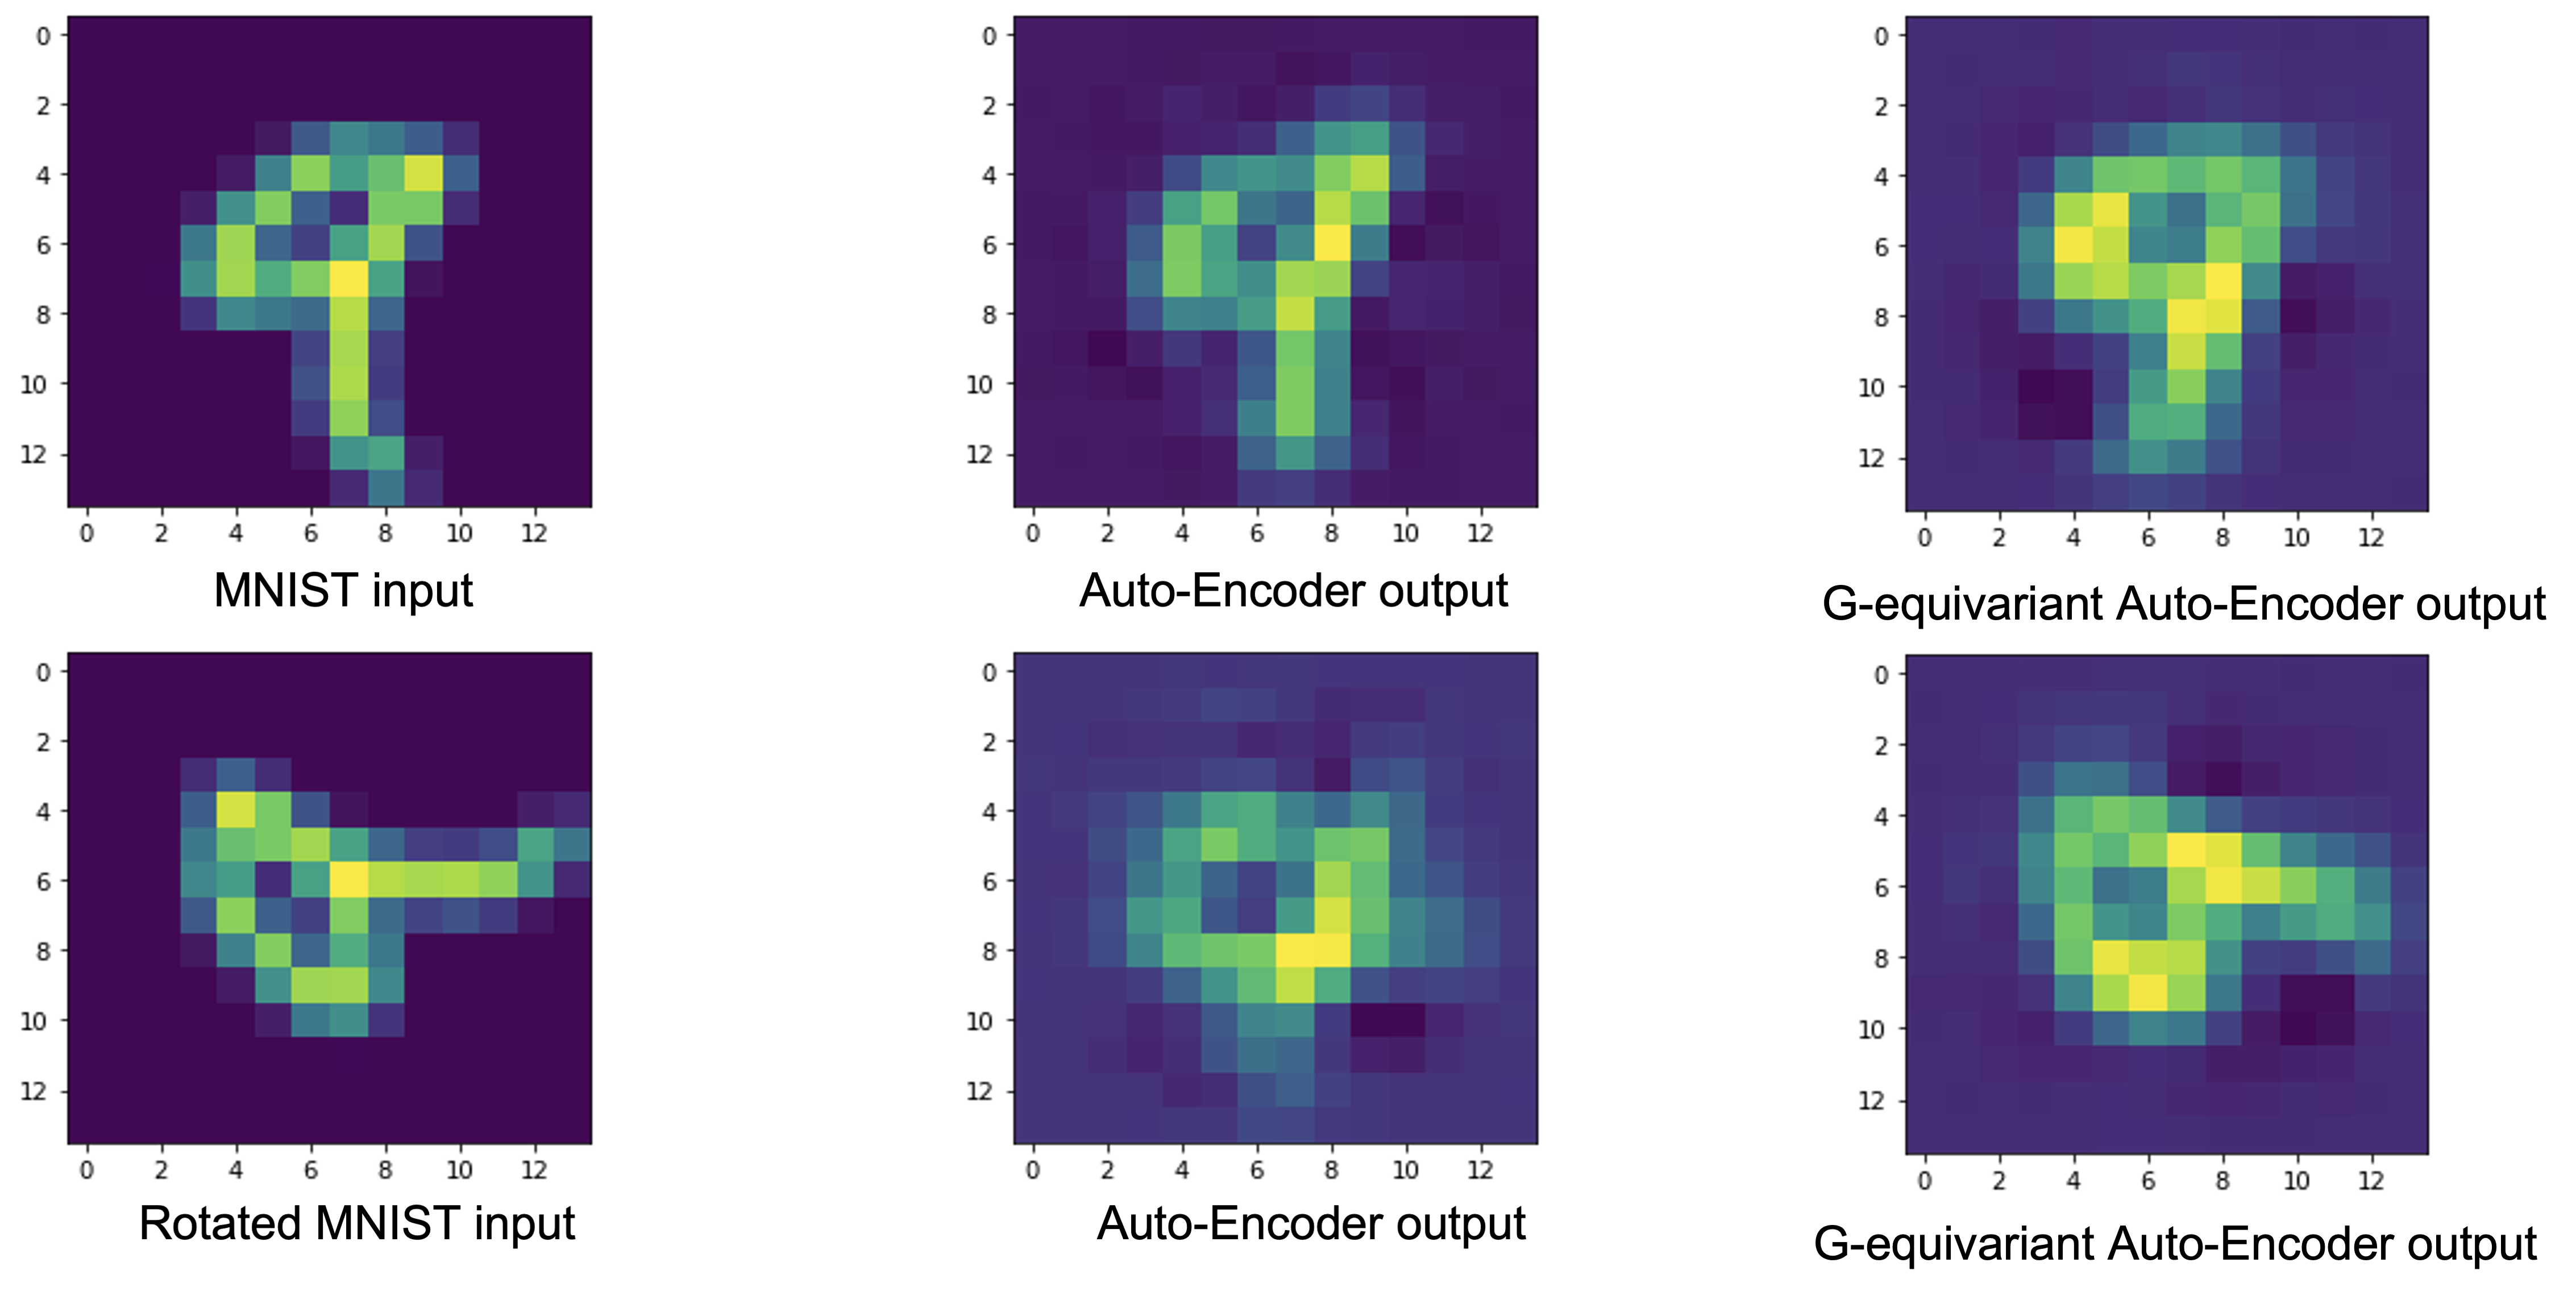We can see the OOD performance is the same as the in-distribution performance. An example can be visualized as such:
<center><img src="example-G-equi-ae-output.png" width=700px /></center>